In [1]:
import torch
import import_ipynb
from dataset import SegmentationDataset
from model import UNet
import config
from torchvision import transforms
from sklearn.model_selection import train_test_split
from imutils import paths
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

importing Jupyter notebook from dataset.ipynb
importing Jupyter notebook from model.ipynb
importing Jupyter notebook from config.ipynb


In [2]:
# Load
unet = UNet().to(config.DEVICE)
checkpoint = torch.load('output/best_model.pth', map_location=config.DEVICE)
unet.load_state_dict(checkpoint['model_state_dict'])
unet.eval()

UNet(
  (e1): Encoder(
    (conv): conv(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (e2): Encoder(
    (conv): conv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [3]:
transforms = transforms.Compose([transforms.ToPILImage(),
    transforms.Resize((config.INPUT_IMAGE_HEIGHT,
        config.INPUT_IMAGE_WIDTH)),
    transforms.ToTensor()])

In [4]:
maskPaths = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))

(_, testImages) = train_test_split(imagePaths, test_size=config.TEST_SPLIT, random_state=42)
(_, testMasks) = train_test_split(maskPaths, test_size=config.TEST_SPLIT, random_state=42)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)

testLoader = DataLoader(testDS, shuffle=False,
    batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
    num_workers=0)

print(f"[INFO] found {len(testDS)} examples in the test set...")

[INFO] found 427 examples in the test set...


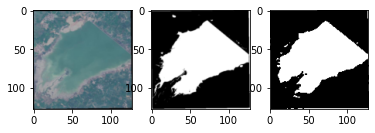

In [62]:
ratio = 0.5
num = 1

image,mask=next(iter(testLoader))
image=image[num]
mask=mask[num]
logits_mask=unet(image.to('cuda', dtype=torch.float32).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > ratio)*1.0

f, axarr = plt.subplots(1,3) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[2].imshow(pred_mask.detach().cpu().squeeze(0).squeeze(0), cmap='gray')